# Introduction

In this project, my goal was to build a robust image-based classifier for eight types of immune blood cells. Because the dataset size is moderate and medical images often benefit from transfer learning, I focused on modern, efficient deep learning pipelines based on pretrained convolutional neural networks rather than training CNNs from scratch.

I applied two complementary families of models:

1. Transfer Learning With Xception (Pretrained ImageNet Model).
- I used the convolutional layers of Xception, pretrained on ImageNet, as a fixed feature extractor:
  - The pretrained convolutional backbone was frozen, i.e., its weights were not updated.
  - A custom classification head was trained on top of these features: GlobalAveragePooling2D, Dense(100, ReLU), Dropout, Dense(8 logits) for the 8 immune-cell classes.
  - Only the classification head was trained from scratch.
  - This approach produced strong performance while keeping training fast and stable. I tuned hyperparameters such as learning rate and dropout rate, and selected the best model based on validation accuracy.
  - This model was evaluated on a held-out test set.


2. Feature Extraction + Classical Machine Learning (logistic regression and XGBoost)
- To complement the neural network, I implemented a second approach: Use Xception (with frozen weights) to extract 2048-dimensional embedding vectors for each image.
- Train classical machine learning models on these embedding vectors: Logistic Regression, XGBoost
- This pipeline converts the image classification problem into a tabular ML problem. It provides simpler models that are easy to train and interpret.
- Logistic regression performed well, reaching as high test accuracy as the MLP head described above, and XGBoost performed overall the worst.

The best-performing model was a transfer-learning Xception classifier with tuned hyperparameters. The classical ML approach (especially logistic regression using Xception embeddings) produced similar test accuracy and very detailed class-level performance metrics.



# Training the model

In [ ]:
# ----------------------------
# Standard library
# ----------------------------
import os
import random
import shutil
import zipfile
from pathlib import Path
from itertools import product

# ----------------------------
# Third-party libraries
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile

# ----------------------------
# Scikit-image
# ----------------------------
from skimage import io, color, transform, feature

# ----------------------------
# Scikit-learn
# ----------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ----------------------------
# ML classifiers
# ----------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# ----------------------------
# TensorFlow / Keras
# ----------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications.xception import (
    Xception,
    preprocess_input,
    decode_predictions,
)

# ----------------------------
# Utilities
# ----------------------------
import pickle
import itertools

In [56]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/snkd93bnjr-1.zip

--2025-11-14 14:21:07--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/snkd93bnjr-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.40.8, 52.92.17.154, 3.5.71.72, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.40.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278867361 (266M) [application/zip]
Saving to: ‘snkd93bnjr-1.zip.1’

snkd93bnjr-1.zip.1  100%[===================>] 265.95M  17.1MB/s    in 16s     

2025-11-14 14:21:24 (16.7 MB/s) - ‘snkd93bnjr-1.zip.1’ saved [278867361/278867361]



In [71]:
zip_path = "snkd93bnjr-1.zip"
extract_dir = "PBC_dataset_normal_DIB"

# Make sure the output directory exists
os.makedirs(extract_dir, exist_ok=True)

# Extract everything
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Correct path to the zip file
zip_path = Path("PBC_dataset_normal_DIB/A dataset for microscopic peripheral blood cell images for development of automatic recognition systems/PBC_dataset_normal_DIB.zip")

# Directory where the zip file is located
extract_dir = zip_path.parent

# Destination: two directories up
destination_dir = extract_dir.parent.parent

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Define source and destination
src = Path("PBC_dataset_normal_DIB/A dataset for microscopic peripheral blood cell images for development of automatic recognition systems/PBC_dataset_normal_DIB")
dst = Path("PBC_dataset_normal_DIB_new")

# Move and rename the folder
shutil.move(str(src), str(dst))
# REmove old folder
shutil.rmtree("PBC_dataset_normal_DIB")

In [72]:
# Split into train 70% / val 15% / test 15%

# Set random seed for reproducibility
random.seed(42)

# Set paths
base_dir = Path("PBC_dataset_normal_DIB_new")
output_dir = base_dir.parent / "PBC_dataset_normal_DIB_split"

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Sanity check
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"

# Create output directories
for split in ["train", "val", "test"]:
    for cls in os.listdir(base_dir):
        (output_dir / split / cls).mkdir(parents=True, exist_ok=True)

# Split each class folder
for cls in os.listdir(base_dir):
    class_dir = base_dir / cls
    if not class_dir.is_dir():
        continue

    images = list(class_dir.glob("*.jpg"))
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    train_files = images[:n_train]
    val_files = images[n_train:n_train + n_val]
    test_files = images[n_train + n_val:]

    # Copy files
    for img_path in train_files:
        shutil.copy(img_path, output_dir / "train" / cls / img_path.name)
    for img_path in val_files:
        shutil.copy(img_path, output_dir / "val" / cls / img_path.name)
    for img_path in test_files:
        shutil.copy(img_path, output_dir / "test" / cls / img_path.name)

print("✅ Dataset successfully split into train/val/test folders.")


✅ Dataset successfully split into train/val/test folders.


In [73]:

# if some files are truncated, .verify() will still fail, but this makes PIL tolerant during open()
ImageFile.LOAD_TRUNCATED_IMAGES = False  # keep strict for cleaning

root = Path("PBC_dataset_normal_DIB_split")
quarantine = root.parent / "quarantine_bad_images"
quarantine.mkdir(exist_ok=True)

def is_image_ok(p: Path) -> bool:
    try:
        with Image.open(p) as im:
            im.verify()  # verify file integrity
        return True
    except Exception:
        return False

bad_files = []
for split in ["train", "val", "test"]:
    for cls_dir in (root / split).iterdir():
        if not cls_dir.is_dir():
            continue
        for p in cls_dir.glob("*"):
            # only check common image extensions; skip others
            if p.suffix.lower() not in {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}:
                bad_files.append(p)
                continue
            if not is_image_ok(p):
                bad_files.append(p)

print(f"Found {len(bad_files)} bad files")
for p in bad_files:
    dest = quarantine / f"{p.parent.name}__{p.name}"
    shutil.move(str(p), str(dest))

print("Moved bad files to:", quarantine)


Found 1 bad files
Moved bad files to: quarantine_bad_images


In [ ]:
base_dir = Path("PBC_dataset_normal_DIB_new")
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory(
    base_dir.parent / 'PBC_dataset_normal_DIB_split/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    base_dir.parent / 'PBC_dataset_normal_DIB_split/val',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_ds = test_gen.flow_from_directory(
    base_dir.parent / 'PBC_dataset_normal_DIB_split/test',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)


base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)


Found 11960 images belonging to 8 classes.
Found 2560 images belonging to 8 classes.
Found 2572 images belonging to 8 classes.


In [75]:
def make_model(
    learning_rate=0.01,
    size_inner=100,
    droprate=0.5,
    output_dense=8
):
    """
    Build and compile an Xception-based image classification model.

    The model uses a pretrained Xception backbone (ImageNet weights) with
    a custom dense head for classification. The base is frozen (not trainable)
    during initial training to focus on the new top layers.

    Parameters
    ----------
    learning_rate : float, optional (default=0.01)
        Learning rate for the Adam optimizer.

    size_inner : int, optional (default=100)
        Number of units in the intermediate dense (fully connected) layer.

    droprate : float, optional (default=0.5)
        Dropout rate applied after the dense layer to prevent overfitting.

    output_dense : int, optional (default=8)
        Number of output units in the final dense layer, corresponding to
        the number of classes.

    Returns
    -------
    model : keras.Model
        A compiled Keras model ready for training.

    Notes
    -----
    - Input images are expected to be resized to (150, 150, 3) and preprocessed
      with `keras.applications.xception.preprocess_input`.
    - The model outputs logits (no softmax applied), so when training,
      use `CategoricalCrossentropy(from_logits=True)`.
    - For fine-tuning, you can unfreeze `base_model` layers after initial training.
    """
    from tensorflow.keras.applications import Xception
    from tensorflow import keras

    # Here I implemented a standard transfer learrning classifier head:
    # GlobalAveragePooling → Dense (ReLU) → Dropout → Dense (8 logits)

    # This loads the convolutional part of Xception that was pretrained on ImageNet (millions of natural images).
    base_model = Xception(
        weights='imagenet',
        # remove the original ImageNet classification head (the dense layers that predicted 1000 classes)
        include_top=False,
        input_shape=(150, 150, 3)
    )

    # freeze all weights in this Xception backbone
    base_model.trainable = False

    # Build the classifier  = a simple fully-connected classifier
    # Everything I added on top of base_model is randomly initialized and trained from scratch:
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    # Takes the 2D feature maps from Xception and averages over spatial dimensions.
    # Output: a 1D feature vector (e.g. 2048-dimensional)
    # This is a common trick to reduce parameters and avoid overfitting.
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    # Applies nonlinearity → lets the model learn a task-specific representation for immune cells.
    # A fully connected layer with size_inner units (I used e.g. 100)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors) # the inner dense layer
    # Helps prevent overfitting
    drop = keras.layers.Dropout(droprate)(inner)
    # Final Dense layer (logits)
    # No activation → outputs logits (raw scores)
    outputs = keras.layers.Dense(output_dense)(drop) # the final classification layer

    model = keras.Model(inputs, outputs)

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    # Keras internally applies softmax when computing the loss.
    # This matches my final Dense layer having no activation
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model


In [62]:
#learning_rates = [0.0001, 0.001, 0.01]
#drop_rates = [0.3, 0.5, 0.7]
#epochs = 30
#
#results = []
#
## Loop over combinations
#for lr, dr in itertools.product(learning_rates, drop_rates):
#    print(f"\nTraining with learning_rate={lr}, droprate={dr}")
#
#    checkpoint = keras.callbacks.ModelCheckpoint(
#     filepath=f"xception_v4_lr{lr}_drop{dr}_"
#             f"{{epoch:02d}}_{{val_accuracy:.3f}}.h5",
#    save_best_only=True,
#    monitor='val_accuracy',
#    mode='max'
#    )
#    model = make_model(learning_rate=lr, droprate=dr)
#    history = model.fit(
#        train_ds,
#        epochs=epochs,
#        validation_data=val_ds,
#        verbose=1,
#        callbacks=[checkpoint]
#    )
#
#    # record per epoch
#    for epoch, (train_acc, val_acc) in enumerate(
#        zip(history.history["accuracy"], history.history["val_accuracy"])
#    ):
#        results.append({
#            "learning_rate": lr,
#            "droprate": dr,
#            "epoch": epoch + 1,
#            "train_acc": train_acc,
#            "val_acc": val_acc
#        })
#with open("scores_v2.pkl", "wb") as f:
#    pickle.dump(results, f)
## Convert results to DataFrame for easy viewing
#df = pd.DataFrame(results)
#print("\nResults summary:")
#print(df.sort_values(by="val_acc", ascending=False))


In [76]:
with open("models/scores_v2.pkl", "rb") as f:
    scores = pickle.load(f)

   learning_rate  droprate  epoch  train_acc   val_acc
1         0.0001       0.5     27   0.912200  0.910972
0         0.0001       0.3     27   0.938624  0.908629
3         0.0010       0.3     16   0.927920  0.908629
4         0.0010       0.5     18   0.888369  0.906287
2         0.0001       0.7     30   0.868635  0.901601
5         0.0010       0.7     21   0.757087  0.896915
6         0.0100       0.3      7   0.766201  0.878563
7         0.0100       0.5     10   0.520779  0.767669
8         0.0100       0.7      1   0.265407  0.463100


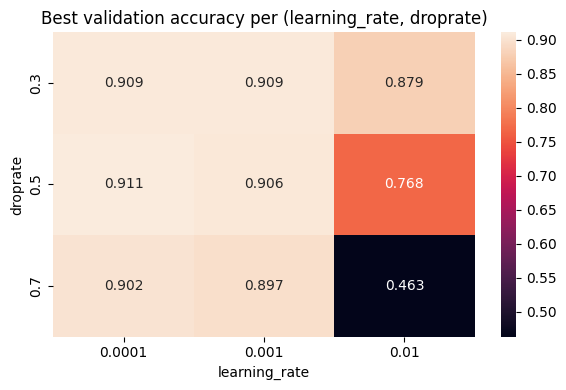

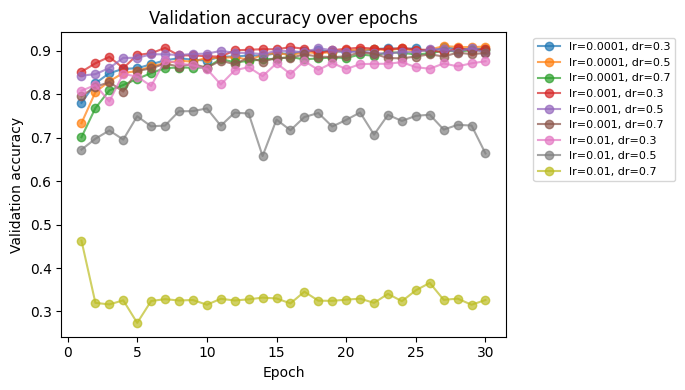

In [77]:
df = pd.DataFrame(scores)

# Get best val_acc per (learning_rate, droprate)
best = (
    df.sort_values("val_acc", ascending=False)
      .groupby(["learning_rate", "droprate"], as_index=False)
      .first()
)
print(best.sort_values("val_acc", ascending=False))

# Pivot for heatmap
pivot = best.pivot(
    index="droprate",
    columns="learning_rate",
    values="val_acc"
)

plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt=".3f")
plt.title("Best validation accuracy per (learning_rate, droprate)")
plt.xlabel("learning_rate")
plt.ylabel("droprate")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))

for (lr, dr), group in df.groupby(["learning_rate", "droprate"]):
    group = group.sort_values("epoch")
    label = f"lr={lr}, dr={dr}"
    plt.plot(group["epoch"], group["val_acc"], marker="o", alpha=0.7, label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy over epochs")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.tight_layout()
plt.show()


To select the final model, I compared validation accuracy across all tested combinations of learning rate and dropout. For each combination, I took the epoch with the highest validation accuracy. Among these, the best-performing configuration was learning rate = 0.0001 and dropout = 0.5, at epoch 27, achieving a training accuracy of 0.912 and a validation accuracy of 0.911. I therefore chose this model checkpoint as my final model, as it provides the highest validation performance while maintaining a reasonable gap between training and validation accuracy (i.e. limited overfitting).

# Using the model

## Aproach 1: image → Xception (frozen) → MLP head → softmax → immune cell type

This model correctly predicted the immune cell type for 92.6% of the test images. This is excellent for multi-class immune cell classification. When it comes to loss, for logits-based training (from_logits=True), values around 0.2-0.4 are normal for a well-performing model.

In [78]:
# load the model
model = keras.models.load_model('models/xception_v4_lr0.0001_drop0.5_27_0.911.h5')
model.evaluate(test_ds)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.9258 - loss: 0.2302


[0.20012815296649933, 0.9346811771392822]

In [79]:
# Get per-class metrics

# 1. Get logits from the model
logits = model.predict(test_ds)

# 2. Convert logits → probabilities (optional, for sanity)
probs = tf.nn.softmax(logits, axis=1).numpy()

# 3. Predicted class indices
y_pred = np.argmax(probs, axis=1)

# 4. True class indices from the generator
y_true = test_ds.classes   # comes from flow_from_directory, in folder order

# 5. Class names in the right order
idx_to_class = {v: k for k, v in test_ds.class_indices.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# 6. Classification report (per class precision/recall/F1)
print(classification_report(y_true, y_pred, target_names=target_names))


81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step
              precision    recall  f1-score   support

    basophil       0.95      0.86      0.90       184
  eosinophil       0.97      0.98      0.97       469
erythroblast       0.94      0.93      0.94       234
          ig       0.84      0.93      0.88       435
  lymphocyte       0.94      0.93      0.93       183
    monocyte       0.89      0.83      0.86       214
  neutrophil       0.96      0.94      0.95       500
    platelet       0.99      0.99      0.99       353

    accuracy                           0.93      2572
   macro avg       0.93      0.92      0.93      2572
weighted avg       0.94      0.93      0.93      2572



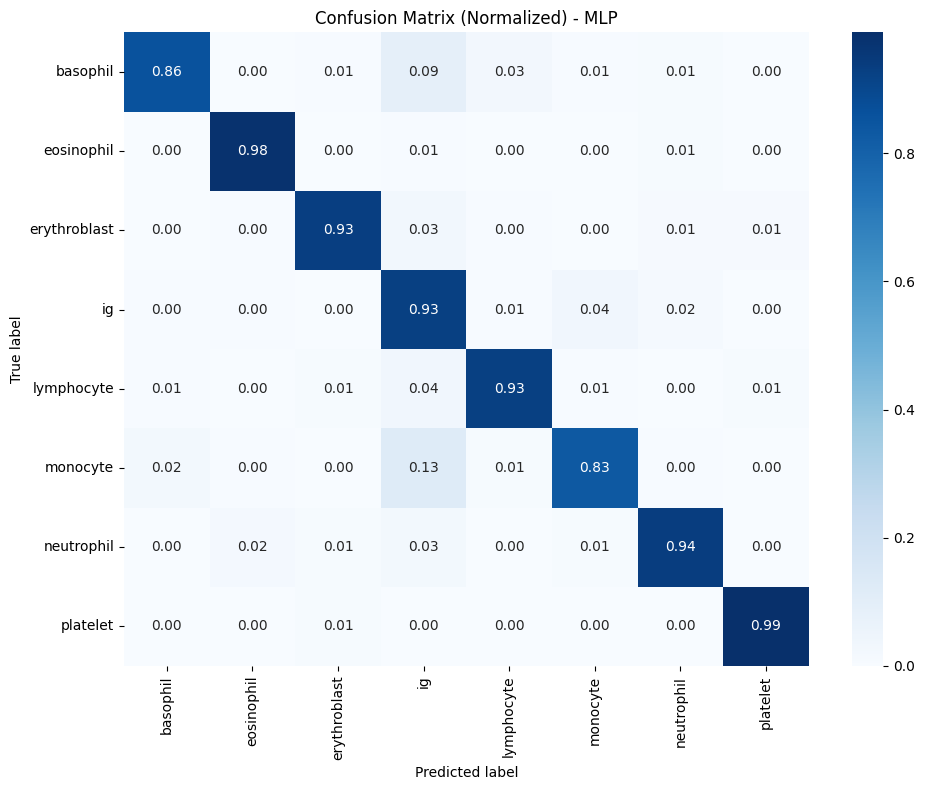

In [80]:
# Confusion matrix (normalized by true class)
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Class names
idx_to_class = {v: k for k, v in test_ds.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Normalized) - MLP")
plt.tight_layout()
plt.show()

approach1_cm = cm.copy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


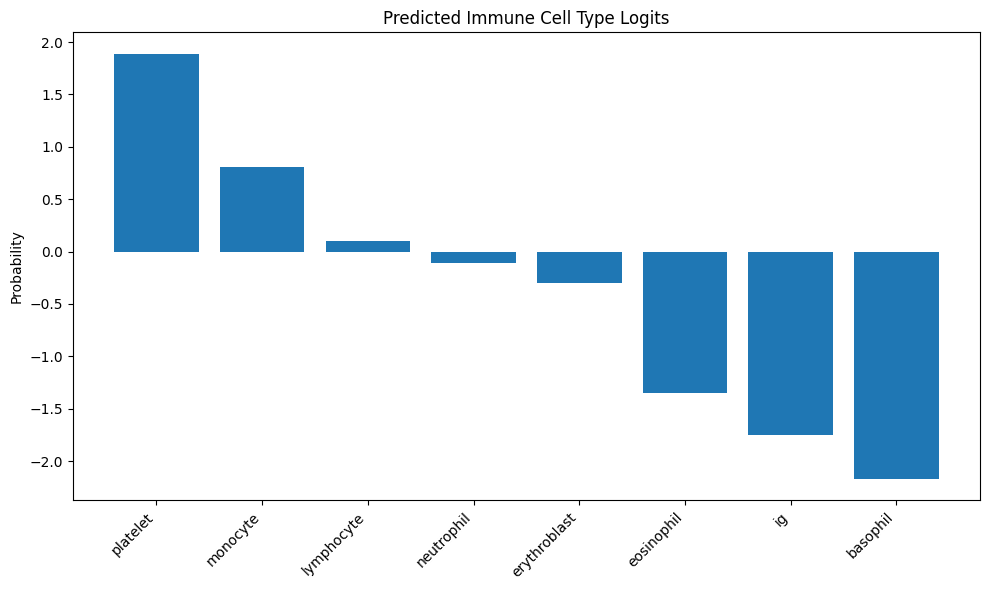

In [ ]:
# Classify a random image
#path = 'PBC_dataset_normal_DIB_split/test/lymphocyte/LY_102859.jpg'
#path = 'PBC_dataset_normal_DIB_split/test/monocyte/MO_104441.jpg'
path = 'PBC_dataset_normal_DIB_split/test/platelet/PLATELET_172256.jpg'

img = load_img(path, target_size=(150, 150))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

logits = model.predict(X)[0]
#probs = tf.nn.softmax(logits).numpy()
classes = [
    'basophil',
    'erythroblast',
    'lymphocyte',
    'neutrophil',
    'eosinophil',
    'ig',
    'monocyte',
    'platelet'
]
prob_dict = dict(zip(classes, logits))

# --- Sort descending by probability ---
sorted_items = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
sorted_classes, sorted_probs = zip(*sorted_items)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.bar(sorted_classes, sorted_probs)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Probability")
plt.title("Predicted Immune Cell Type Logits")
plt.tight_layout()
plt.show()

## Aproach 2: image → Xception → 2048-d embedding → classical ML → immune cell type

### Logistic regression



In [82]:
# Load pretrained Xception base (ImageNet)
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False  # keep it frozen

# Add GAP so we get a 1D feature vector per image
gap_output = keras.layers.GlobalAveragePooling2D()(base_model.output)
feature_extractor = keras.Model(inputs=base_model.input, outputs=gap_output)


In [83]:
# feature extraction, and it requires running Xception on every single image

# helper: get features + labels from a generator
def extract_features_labels(dataset, feature_model):
    # N = number of images
    N = dataset.samples
    # dim = length of feature vector (e.g. 2048)
    sample_batch = next(dataset)[0]
    dim = feature_model.predict(sample_batch[:1]).shape[1]

    # reset generator to start from beginning
    dataset.reset()

    # allocate
    features = np.zeros((N, dim), dtype='float32')
    labels = np.zeros(N, dtype='int32')

    i = 0
    for batch_x, batch_y in dataset:
        # batch size might be smaller in last batch
        bs = batch_x.shape[0]

        # get features
        feats = feature_model.predict(batch_x, verbose=0)
        features[i:i+bs] = feats

        # y is one-hot; take argmax to get integer class index
        labels[i:i+bs] = np.argmax(batch_y, axis=1)

        i += bs
        if i >= N:
            break
    # features: 2048-dimensional embedding vector; the numerical representation of each image extracted by Xception
    # labels: the class indices for each image.
    return features, labels

X_train, y_train = extract_features_labels(train_ds, feature_extractor)
X_val,   y_val   = extract_features_labels(val_ds,   feature_extractor)
X_test,  y_test  = extract_features_labels(test_ds,  feature_extractor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [84]:
# multinomial LR for multi-class softmax
logreg = LogisticRegression(
    max_iter=2000,
    multi_class='multinomial',
    solver='lbfgs',
    n_jobs=-1
)

logreg.fit(X_train, y_train)

# evaluate on test set
y_pred = logreg.predict(X_test)
print("Test accuracy (LogReg):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=test_ds.class_indices.keys()))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test accuracy (LogReg): 0.9031881804043546
              precision    recall  f1-score   support

    basophil       0.89      0.83      0.86       184
  eosinophil       0.97      0.95      0.96       469
erythroblast       0.89      0.92      0.90       234
          ig       0.83      0.85      0.84       435
  lymphocyte       0.87      0.91      0.89       183
    monocyte       0.79      0.78      0.78       214
  neutrophil       0.92      0.93      0.92       500
    platelet       0.99      0.98      0.98       353

    accuracy                           0.90      2572
   macro avg       0.89      0.89      0.89      2572
weighted avg       0.90      0.90      0.90      2572



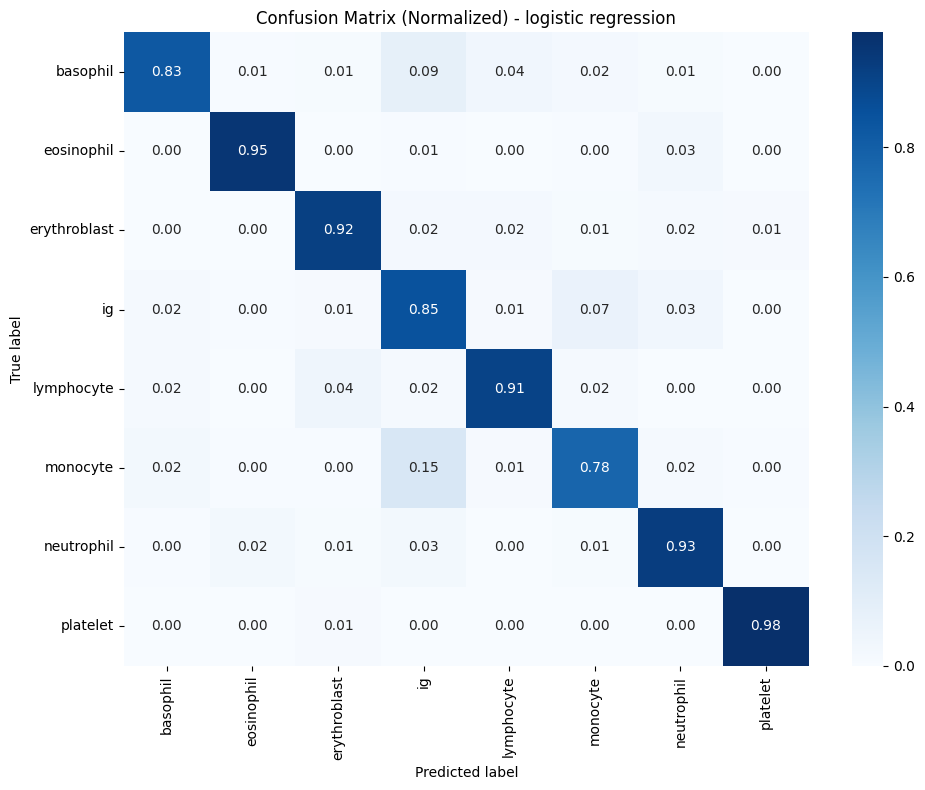

In [85]:
# Confusion matrix (normalized by true class)
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Class names
idx_to_class = {v: k for k, v in test_ds.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Normalized) - logistic regression")
plt.tight_layout()
plt.show()

approach2_logreg_cm = cm.copy()

### XGBoost


In [86]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="mlogloss",
    early_stopping_rounds=20     # <-- must be here in XGB ≥ 2.0
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-mlogloss:1.98718
[1]	validation_0-mlogloss:1.92158
[2]	validation_0-mlogloss:1.86261
[3]	validation_0-mlogloss:1.80845
[4]	validation_0-mlogloss:1.75650
[5]	validation_0-mlogloss:1.70881
[6]	validation_0-mlogloss:1.66502
[7]	validation_0-mlogloss:1.62419
[8]	validation_0-mlogloss:1.58544
[9]	validation_0-mlogloss:1.54987
[10]	validation_0-mlogloss:1.51473
[11]	validation_0-mlogloss:1.48197
[12]	validation_0-mlogloss:1.45110
[13]	validation_0-mlogloss:1.42093
[14]	validation_0-mlogloss:1.39257
[15]	validation_0-mlogloss:1.36610
[16]	validation_0-mlogloss:1.34011
[17]	validation_0-mlogloss:1.31734
[18]	validation_0-mlogloss:1.29401
[19]	validation_0-mlogloss:1.27088
[20]	validation_0-mlogloss:1.24996
[21]	validation_0-mlogloss:1.22913
[22]	validation_0-mlogloss:1.20961
[23]	validation_0-mlogloss:1.19047
[24]	validation_0-mlogloss:1.17197
[25]	validation_0-mlogloss:1.15397
[26]	validation_0-mlogloss:1.13673
[27]	validation_0-mlogloss:1.11979
[28]	validation_0-mlogloss:1.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)

In [88]:
#with open("models/xgb_immune_classifier.pkl", "wb") as f:
#    pickle.dump(xgb, f)
with open("models/xgb_immune_classifier.pkl", "rb") as f:
    xgb = pickle.load(f)

XGBoost val accuracy: 0.8308709175738724


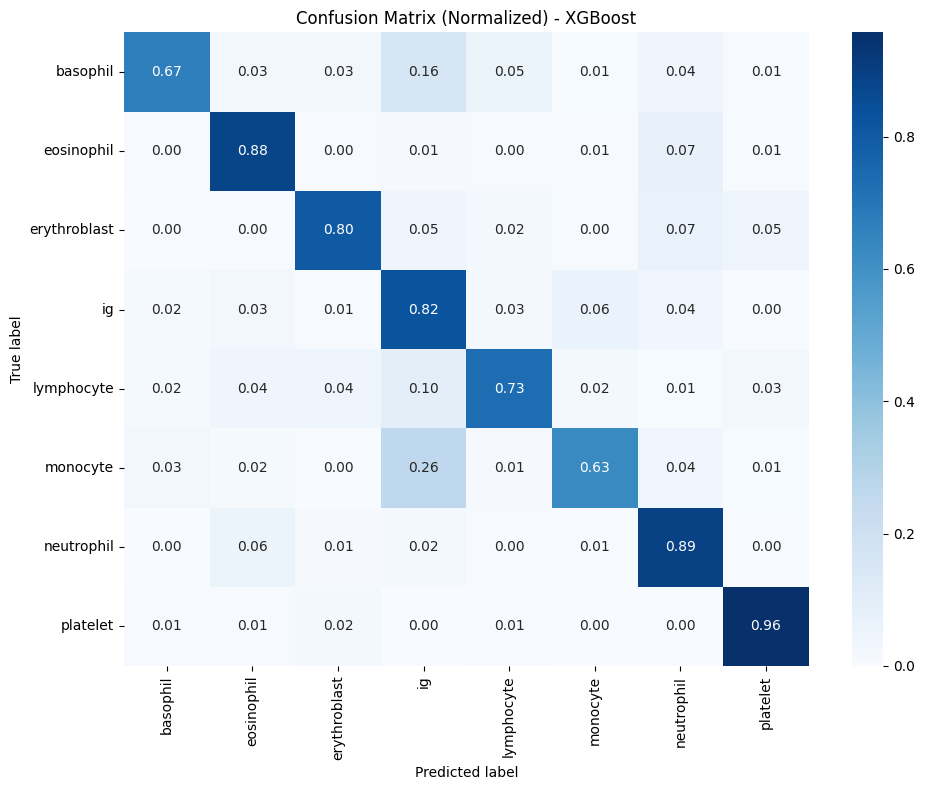

In [93]:


y_pred = xgb.predict(X_test)
print("XGBoost val accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix (normalized by true class)
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Class names
idx_to_class = {v: k for k, v in test_ds.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Normalized) - XGBoost")
plt.tight_layout()
plt.show()

approach2_XGBoost_cm = cm.copy()

# Save the best performing model using Tenserflow-Lite

In [96]:
model = keras.models.load_model('models/xception_v4_lr0.0001_drop0.5_27_0.911.h5')
# Check results for a random image
path = 'PBC_dataset_normal_DIB_split/test/platelet/PLATELET_172256.jpg'
img = load_img(path, target_size=(150, 150))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
preds = model.predict(X)
print("The original tensorflow model:")
print(dict(zip(classes, preds[0])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
The original tensorflow model:
{'basophil': np.float32(-2.1733735), 'erythroblast': np.float32(-0.2962469), 'lymphocyte': np.float32(0.098879576), 'neutrophil': np.float32(-0.10777752), 'eosinophil': np.float32(-1.3473179), 'ig': np.float32(-1.748101), 'monocyte': np.float32(0.803979), 'platelet': np.float32(1.8902905)}


In [97]:
# Convert Keras to TF-Lite
# Convert to tenserflowlight to reduce the size of the model on the disk
import tensorflow.lite as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpbinr93nv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  136736541566992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736541569488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736541560272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736541569680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736541569872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736541568720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736541567760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736541571216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736541567184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136736541571984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1367365415710

In [98]:
# Open the new lighter model and check if I still get the same results
with open('xception_v4_lr0.0001_drop0.5_27_0.911.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

In [99]:
interpreter = tflite.Interpreter(model_path='xception_v4_lr0.0001_drop0.5_27_0.911.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

# Check results for a random image using the light tenserflow version fo the model
print("The light tensorflow model:")
print(dict(zip(classes, preds[0])))

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


The light tensorflow model:
{'basophil': np.float32(-2.1733785), 'erythroblast': np.float32(-0.29625005), 'lymphocyte': np.float32(0.09888415), 'neutrophil': np.float32(-0.107780464), 'eosinophil': np.float32(-1.3473179), 'ig': np.float32(-1.7481018), 'monocyte': np.float32(0.8039806), 'platelet': np.float32(1.8902962)}


In [101]:
# -----------------------------------
# Remove tensorflow dependency for the sake of docker image
from PIL import Image
with Image.open(path) as img:
    img = img.resize((150, 150), Image.NEAREST)
def preprocess_input(x):
    x /= 127.5
    x -= 1.
    return x
x = np.array(img, dtype='float32')
X = np.array([x])
X = preprocess_input(X)
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)
print("The light tensorflow model without tf dependency:")
print(dict(zip(classes, preds[0])))

The light tensorflow model without tf dependency:
{'basophil': np.float32(-2.1733785), 'erythroblast': np.float32(-0.29625005), 'lymphocyte': np.float32(0.09888415), 'neutrophil': np.float32(-0.107780464), 'eosinophil': np.float32(-1.3473179), 'ig': np.float32(-1.7481018), 'monocyte': np.float32(0.8039806), 'platelet': np.float32(1.8902962)}
